### Loading the dataset

In [1]:
import numpy
import pandas as pd

Delivery_truck_trip_data_df = pd.read_csv('temp/Delivery_truck_trip_data_df.csv')


In [2]:
X = Delivery_truck_trip_data_df.drop(['anomaly'], axis=1)

### Normalizing

In [3]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X = qt.fit_transform(X)


### Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [5]:
df = pd.DataFrame(X)
df = pd.concat([df, Delivery_truck_trip_data_df['anomaly']], axis=1)


### Splitting the dataset

In [6]:
# Separate the records based on the label
normal_records = df[df['anomaly'] == False]
anomaly_records = df[df['anomaly'] == True]

X_normal_records = normal_records.drop(['anomaly'], axis=1)
y_normal_records = normal_records['anomaly']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normal_records, y_normal_records, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


In [7]:
# Randomly sample an equal number of False records
anomaly_records_sampled = anomaly_records.sample(n=len(test))

# First DataFrame: Equal number of True and False records
df_test = pd.concat([test, anomaly_records_sampled]).sample(frac=1).reset_index(drop=True)

# Second DataFrame: Remaining False records
df_remaining_normal = train.reset_index(drop=True)


In [8]:
X_anomaly = anomaly_records.drop(['anomaly'], axis=1).to_numpy()
X_test = df_test.drop(['anomaly'], axis=1).to_numpy()
y_test = df_test['anomaly'].map({True: -1, False: 1}).to_numpy()
X_normal = df_remaining_normal.drop(['anomaly'], axis=1).to_numpy()
y_normal = df_remaining_normal['anomaly'].map({True: -1, False: 1}).to_numpy()


In [9]:
y_test

array([ 1, -1, -1, ..., -1,  1, -1])

### Import Necessary Libraries:

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim


### Define the Autoencoder Architecture

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(19, 15),  # Assuming the first hidden layer has 12 nodes
            nn.ReLU(),
            nn.Linear(15, 11),   # Further compressing to 8 nodes
            nn.ReLU(),
            nn.Linear(11, 7)
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(7, 11),
            nn.ReLU(),
            nn.Linear(11, 15),
            nn.ReLU(),
            nn.Linear(15, 19),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)


### Instantiate the Model, Loss Function, and Optimizer

In [12]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


### Convert DataFrame to PyTorch Tensor

In [13]:
tensor_data_test = torch.Tensor(X_test)
tensor_data_normal = torch.Tensor(X_normal)
tensor_data_anomaly  = torch.Tensor(X_anomaly)

### DataLoader

In [14]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(tensor_data_normal)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


### Training Loop

In [15]:
# Example training loop
num_epochs = 300
for epoch in range(num_epochs):
    for batch_features, in train_loader:  # DataLoader will unpack the features
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/300], Loss: 0.0521
Epoch [2/300], Loss: 0.0496
Epoch [3/300], Loss: 0.0518
Epoch [4/300], Loss: 0.0508
Epoch [5/300], Loss: 0.0503
Epoch [6/300], Loss: 0.0487
Epoch [7/300], Loss: 0.0477
Epoch [8/300], Loss: 0.0452
Epoch [9/300], Loss: 0.0441
Epoch [10/300], Loss: 0.0451
Epoch [11/300], Loss: 0.0429
Epoch [12/300], Loss: 0.0414
Epoch [13/300], Loss: 0.0369
Epoch [14/300], Loss: 0.0341
Epoch [15/300], Loss: 0.0318
Epoch [16/300], Loss: 0.0264
Epoch [17/300], Loss: 0.0240
Epoch [18/300], Loss: 0.0222
Epoch [19/300], Loss: 0.0238
Epoch [20/300], Loss: 0.0211
Epoch [21/300], Loss: 0.0232
Epoch [22/300], Loss: 0.0204
Epoch [23/300], Loss: 0.0211
Epoch [24/300], Loss: 0.0175
Epoch [25/300], Loss: 0.0172
Epoch [26/300], Loss: 0.0158
Epoch [27/300], Loss: 0.0143
Epoch [28/300], Loss: 0.0188
Epoch [29/300], Loss: 0.0174
Epoch [30/300], Loss: 0.0192
Epoch [31/300], Loss: 0.0115
Epoch [32/300], Loss: 0.0161
Epoch [33/300], Loss: 0.0149
Epoch [34/300], Loss: 0.0141
Epoch [35/300], Loss: 0

### Calculate Reconstruction Errors

In [16]:
model.eval()
normal_losses = []
test_losses = []
# anomaly_losses = []

with torch.no_grad():
    for normal in tensor_data_normal:
        reconstruction = model(normal.unsqueeze(0))
        loss = criterion(reconstruction, normal.unsqueeze(0))
        normal_losses.append(loss.item())

    for test in tensor_data_test:
        reconstruction = model(test.unsqueeze(0))
        loss = criterion(reconstruction, test.unsqueeze(0))
        test_losses.append(loss.item())

    '''
    for anomaly in tensor_data_anomaly:
        reconstruction = model(anomaly.unsqueeze(0))
        loss = criterion(reconstruction, anomaly.unsqueeze(0))
        anomaly_losses.append(loss.item())
    '''


### Separate Errors Based on Labels

In [17]:
normal_test_errors = [test_losses[i] for i in range(len(y_test)) if y_test[i]==1]
anomaly_test_errors = [test_losses[i] for i in range(len(y_test)) if y_test[i]==-1]

### Plot the Distribution

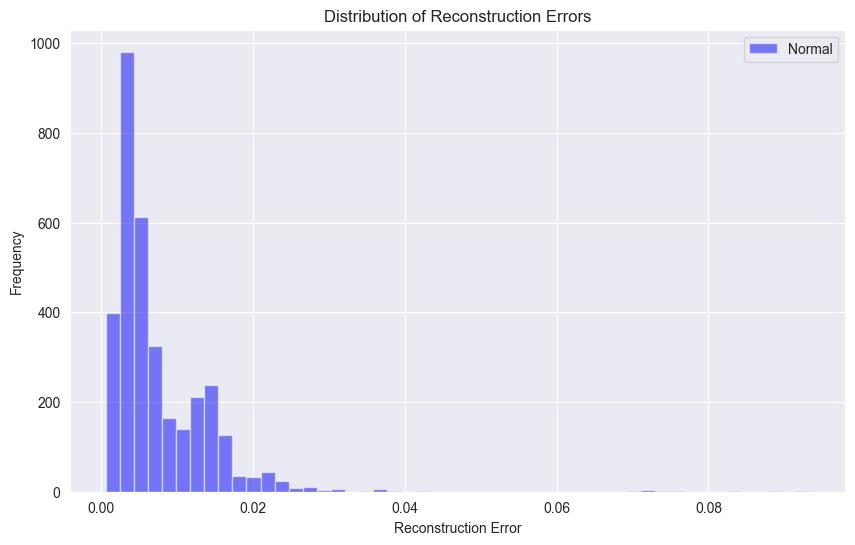

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_losses, bins=50, alpha=0.5, color="blue", label="Normal")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.savefig('temp/normal.png')

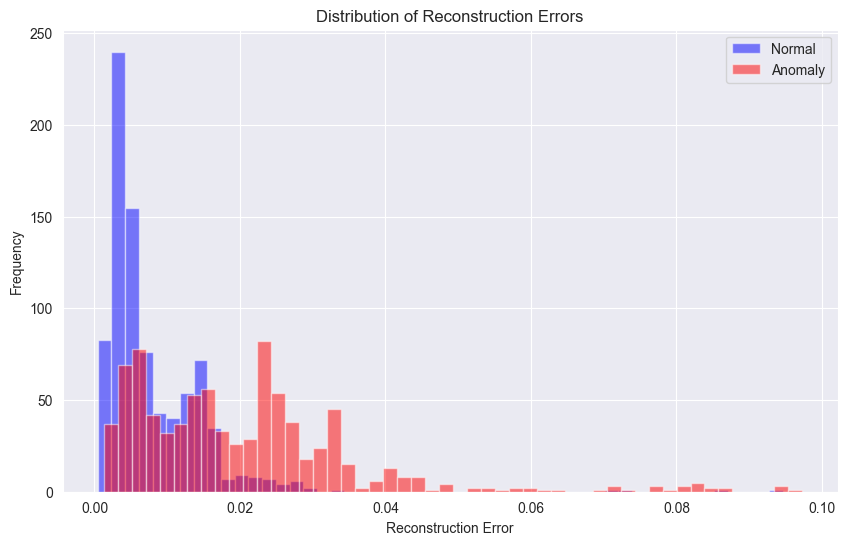

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_test_errors, bins=50, alpha=0.5, color="blue", label="Normal")
plt.hist(anomaly_test_errors, bins=50, alpha=0.5, color="red", label="Anomaly")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.savefig('temp/test.png')

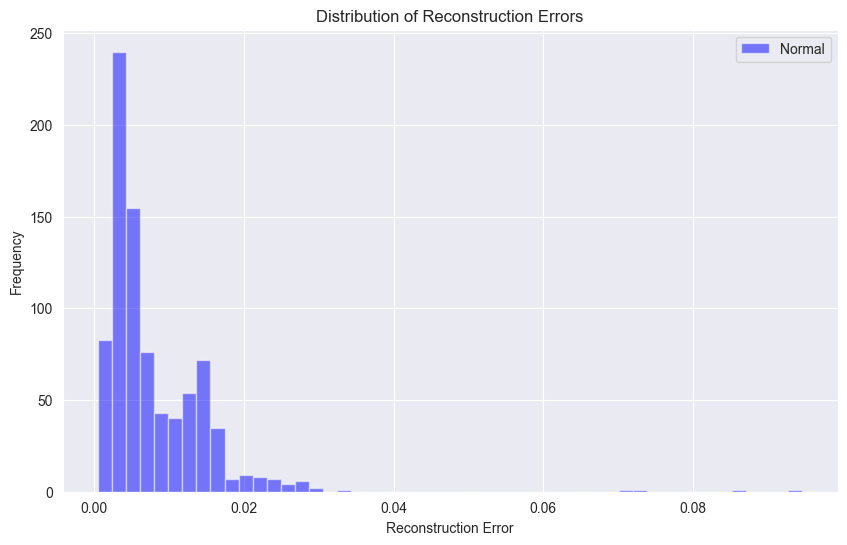

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_test_errors, bins=50, alpha=0.5, color="blue", label="Normal")
# plt.hist(anomaly_test_errors, bins=50, alpha=0.5, color="red", label="Anomaly")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.savefig('temp/test.png')

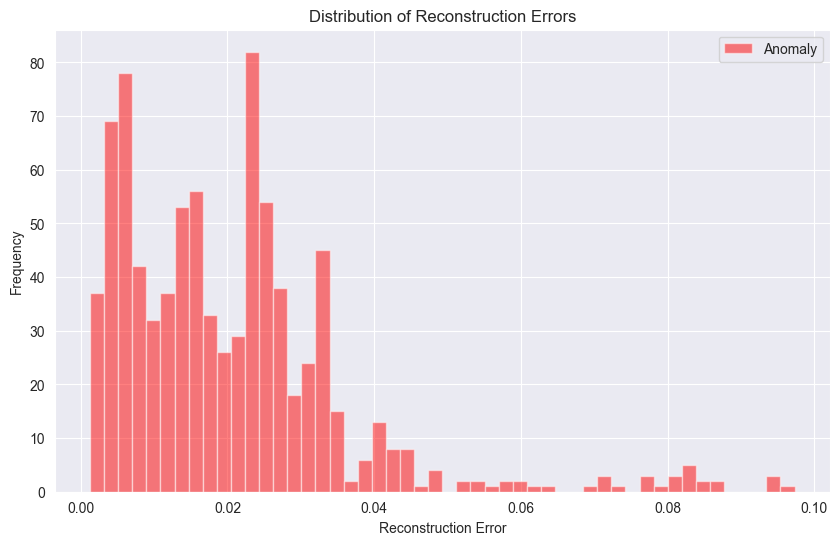

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# plt.hist(normal_test_errors, bins=50, alpha=0.5, color="blue", label="Normal")
plt.hist(anomaly_test_errors, bins=50, alpha=0.5, color="red", label="Anomaly")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.savefig('temp/test.png')

The threshold value for the reconstruction error is set at 0.01.

### Performance

In [57]:
y_pred = [-1 if i > 0.01 else 1 for i in test_losses]

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

          -1       0.72      0.81      0.76       846
           1       0.78      0.69      0.73       846

    accuracy                           0.75      1692
   macro avg       0.75      0.75      0.74      1692
weighted avg       0.75      0.75      0.74      1692


array([[682, 164],
       [266, 580]])

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np

table_of_performance = pd.DataFrame(columns=['algorithm', 'confusion matrix', 'accuracy', 'precision', 'recall'])

def add_performance(algorithm, y_test, y_predict):
    global table_of_performance

    cm = confusion_matrix(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    new_row = {'algorithm': algorithm, 'confusion matrix': cm, 'accuracy': accuracy, 'precision': precision, 'recall': recall}

    table_of_performance.loc[len(table_of_performance)] = new_row


add_performance('One-class autoencoder', (y_test!=1), (np.array(y_pred)!=1))
table_of_performance

,algorithm,confusion matrix,accuracy,precision,recall
0,One-class-SVM,"[[580, 266], [164, 682]]",0.745863,0.719409,0.806147


In [60]:
type(y_pred)

list